In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder  # OBBLIGATORIO DA USARE
from tensorflow.keras.utils import to_categorical  # OBBLIGATORIO DA USARE
from io import TextIOWrapper

# from tqdm.notebook import tqdm
from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from scipy.signal import hilbert

In [2]:
def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Estrae il file ZIP se la cartella di destinazione non esiste già.
    
    Args:
        zip_path (str): Percorso al file ZIP
        extract_to (str, optional): Cartella dove estrarre i file. Se None, usa il nome del file ZIP.
    
    Returns:
        str: Percorso alla cartella estratta
    """
    
    # Se la directory di estrazione non è specificata, usa il nome del file ZIP
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]
    
    # Controlla se la directory di estrazione esiste già
    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"La directory '{extract_to}' esiste già, l'estrazione verrà saltata.")
        return extract_to
    
    # Estrai lo ZIP se esiste
    if os.path.exists(zip_path):
        print(f"Estrazione di '{zip_path}' in '{extract_to}'...")
        
        # Ottieni la lista dei file nello ZIP per la progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)
        
        # Estrai i file con progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Estrazione files", total=total_files):
                zip_ref.extract(file, extract_to)
        
        print(f"Estrazione completata in '{extract_to}'")
    else:
        raise FileNotFoundError(f"Il file ZIP '{zip_path}' non esiste.")
    
    return extract_to



def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [3]:
# Percorso assoluto del file ZIP
# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")


# Estrai lo ZIP se necessario
extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")

# Leggi il file di annotazione
# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


In [ ]:
# FEATURE EXTRACTION

spectograms = []
spectral_centroids = []
spectral_rolloffs = []
spectral_contrasts = []
low_freq_energies = []
fixed_length = None

ild_features = []
ipd_features = []

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

def compute_ild_ipd(left, right):
    """
    Calcola ILD e IPD da due canali separati.
    """
    eps = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        ild = 20 * np.log10(np.abs(left) / (np.abs(right) + eps))
        ild[np.isinf(ild)] = 0  # sostituisci inf con 0
    
    analytic_left = hilbert(left)
    analytic_right = hilbert(right)
    phase_left = np.angle(analytic_left)
    phase_right = np.angle(analytic_right)
    ipd = phase_left - phase_right
    ipd = (ipd + np.pi) % (2 * np.pi) - np.pi
    
    ild_stats = np.array([np.mean(ild), np.std(ild), np.max(ild), np.median(ild)])
    ipd_stats = np.array([np.mean(ipd), np.std(ipd), np.max(ipd), np.median(ipd)])
    
    return ild_stats, ipd_stats



for audio_path in all_audio_files[:]:

    y, sr = librosa.load(audio_path, sr=None, mono=False)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Caratteristiche che aiutano a distinguere car/truck

    # 1 centroide per ogni frame
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # 1 rolloff per ogni frame
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # 1 contrasto per banda (default 6+1 bande)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    low_freq_energy = np.sum(mel_spectrogram[:10, :]) / (np.sum(mel_spectrogram) + 1e-10)

    if fixed_length is None:
        fixed_length = mel_spectrogram_db.shape[1]
    
    # Padding o troncamento
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                    ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    # Normalizzazione
    mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)


    # Calcolo ILD e IPD
    # ild_stats, ipd_stats = compute_ild_ipd(left, right)
    
    spectograms.append(mel_spectrogram_db) 
    spectral_centroids.append(spectral_centroid)
    spectral_rolloffs.append(spectral_rolloff)
    spectral_contrasts.append(spectral_contrast)
    low_freq_energies.append(low_freq_energy)      

    # ILD/IPD stats
    ild_stats, ipd_stats = compute_ild_ipd(y[0], y[1])  # Assuming stereo audio
    ild_features.append(ild_stats)
    ipd_features.append(ipd_stats)


spectograms = np.array(spectograms)
spectograms = spectograms / np.max(np.abs(spectograms))

spectral_centroids = np.array(spectral_centroids)
spectral_rolloffs = np.array(spectral_rolloffs)
spectral_contrasts = np.array(spectral_contrasts)
low_freq_energies = np.array(low_freq_energies)

ild_features = np.array(ild_features)
ipd_features = np.array(ipd_features)

input_shape = spectograms.shape[1:]
print(spectograms.shape)
print()
print(spectral_centroids.shape)
print(spectral_rolloffs.shape)
print(spectral_contrasts.shape)
print(low_freq_energies.shape)
print()
print(input_shape)


(17506, 2, 128, 188)

(17506, 1, 188)
(17506, 1, 188)
(17506, 2, 188)
(17506,)

(2, 128, 188)


In [ ]:
# 1. Estrai statistiche dalle feature temporali
def extract_stats(feature):
    # First calculate statistics across the time/feature dimension (axis=2)
    mean_val = np.mean(feature, axis=2)
    std_val = np.std(feature, axis=2)
    max_val = np.max(feature, axis=2)
    median_val = np.median(feature, axis=2)
    
    # Reshape to remove the middle dimension of 1 and stack the statistics along a new dimension
    # This will result in shape (17506, 4)
    return np.column_stack([
        mean_val.reshape(-1),
        std_val.reshape(-1),
        max_val.reshape(-1),
        median_val.reshape(-1)
    ])

# Applica a centroid e rolloff
centroid_stats = extract_stats(spectral_centroids)  # (17506, 4)
rolloff_stats = extract_stats(spectral_rolloffs)    # (17506, 4) 
contrast_stats_left = extract_stats(spectral_contrasts[:, :spectral_contrasts.shape[1] // 2, :])  # Left channel
contrast_stats_right = extract_stats(spectral_contrasts[:, spectral_contrasts.shape[1] // 2:, :])  # Right channel

print(f"Centroid stats shape: {centroid_stats.shape}")
print(f"Rolloff stats shape: {rolloff_stats.shape}")
print(f"Contrast stats shape (left): {contrast_stats_left.shape}")
print(f"Contrast stats shape (right): {contrast_stats_right.shape}")
print(f"Low frequency energies shape: {low_freq_energies.shape}")
print(f"ILD features shape: {ild_features.shape}")
print(f"IPD features shape: {ipd_features.shape}")

# Combina tutte le feature audio (tranne spettrogrammi)
audio_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1),   # (17506, 1)
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 25)

# "Cleaning" of audio features
audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizza le feature audio
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

print()
print(audio_features_scaled.shape)

Centroid stats shape: (17506, 4)
Rolloff stats shape: (17506, 4)
Contrast stats shape (left): (17506, 4)
Contrast stats shape (right): (17506, 4)
Low frequency energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)

(17506, 25)


In [20]:
def plot_and_evaluate_single_output_model(history, y_true, y_pred, class_names=None):
    """
    Visualizza le metriche di addestramento e genera il classification report
    per un modello con singolo output usando predizioni pre-calcolate.
    
    Args:
        history: Oggetto history restituito da model.fit()
        y_true: Label vere (indici di classe, non one-hot encoded)
        y_pred: Predizioni del modello (indici di classe, non one-hot encoded)
        class_names: Lista con i nomi delle classi (opzionale)
    """
    
    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(12, 5))
    
    # Grafico per l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico per la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Trova e stampa la migliore accuracy
    best_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_acc) + 1
    
    print(f"Miglior accuracy: {best_acc:.4f} (epoch {best_epoch})")
    
    # Se non sono forniti i nomi delle classi, usa etichette numeriche
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    # Genera e stampa il classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Visualizza la matrice di confusione
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [23]:
# Balanced dataset creation
def create_balanced_dataset(spectrograms, audio_features, vehicle_labels, direction_labels, target_count=None, random_state=42):
    '''
    Parameters:
        spectrograms: Gli spettrogrammi come array 4D
        audio_features: Le feature audio come array 2D
        vehicle_labels: Le etichette dei veicoli (one-hot encoded)
        direction_labels: Le etichette di direzione (one-hot encoded)
        target_count: numero a cui croppare le categorie in eccesso
        random_state: seed per riproducibilità
    
    Returns:
        balanced_spectrograms, balanced_audio_features, balanced_vehicle_labels, balanced_direction_labels
    '''
    # Convert one-hot encoded labels back to indices
    vehicle_indices = np.argmax(vehicle_labels, axis=1)
    
    # Count samples per class
    unique_classes, class_counts = np.unique(vehicle_indices, return_counts=True)
    class_distribution = dict(zip(unique_classes, class_counts))
    print("Original class distribution:", 
          {le_vehicle.classes_[cls]: count for cls, count in class_distribution.items()})
    
    # Determine target count (you can adjust this as needed)
    # Using the minimum class count as target ensures all classes have equal representation
    if target_count == None:
        target_count = min(class_counts)
    print(f"Target count per class: {target_count}")
    
    # Create balanced dataset
    balanced_indices = []
    np.random.seed(random_state)
    
    for class_idx in unique_classes:
        # Get indices of samples from this class
        class_sample_indices = np.where(vehicle_indices == class_idx)[0]
        
        # If class is overrepresented, randomly select target_count samples
        if len(class_sample_indices) > target_count:
            selected_indices = np.random.choice(class_sample_indices, target_count, replace=False)
        else:
            selected_indices = class_sample_indices
            
        balanced_indices.extend(selected_indices)
    
    # Shuffle the balanced dataset
    np.random.shuffle(balanced_indices)
    
    # Create the balanced dataset
    balanced_spectrograms = spectrograms[balanced_indices]
    balanced_vehicle_labels = vehicle_labels[balanced_indices]
    balanced_direction_labels = direction_labels[balanced_indices]

    balanced_audio_features = audio_features[balanced_indices]
    
    # Verify balanced distribution
    new_counts = np.unique(np.argmax(balanced_vehicle_labels, axis=1), return_counts=True)
    print("Balanced class distribution:", 
          {le_vehicle.classes_[cls]: count for cls, count in zip(new_counts[0], new_counts[1])})
    
    return balanced_spectrograms, balanced_audio_features, balanced_vehicle_labels, balanced_direction_labels

Original class distribution: {'B': np.int64(106), 'C': np.int64(7804), 'M': np.int64(430), 'None': np.int64(8144), 'T': np.int64(1022)}
Target count per class: 3000
Balanced class distribution: {'B': np.int64(106), 'C': np.int64(3000), 'M': np.int64(430), 'None': np.int64(3000), 'T': np.int64(1022)}

Number of audio files per vehicle class (Original Full Dataset):
vehicle
None    8144
C       7804
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Full Dataset):
None    3000
C       3000
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Training Set):
B         80
C       2070
M        305
None    2137
T        698
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Validation Set):
B        16
C       463
M        63
None    430
T       162
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Test Set):
B   

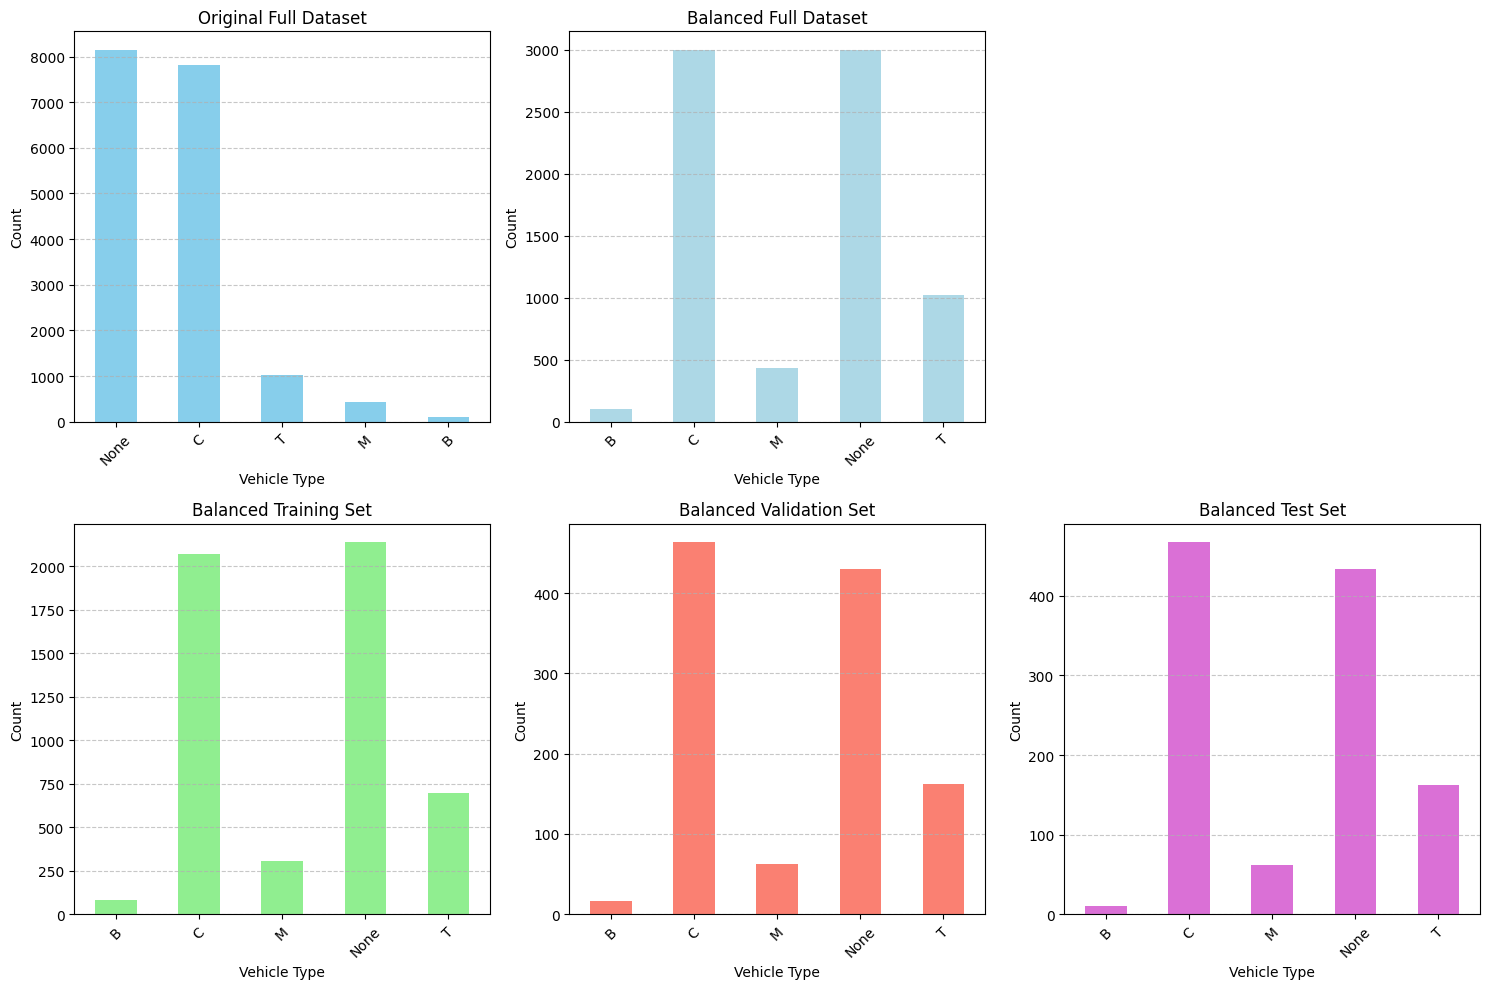

<Figure size 1200x600 with 0 Axes>

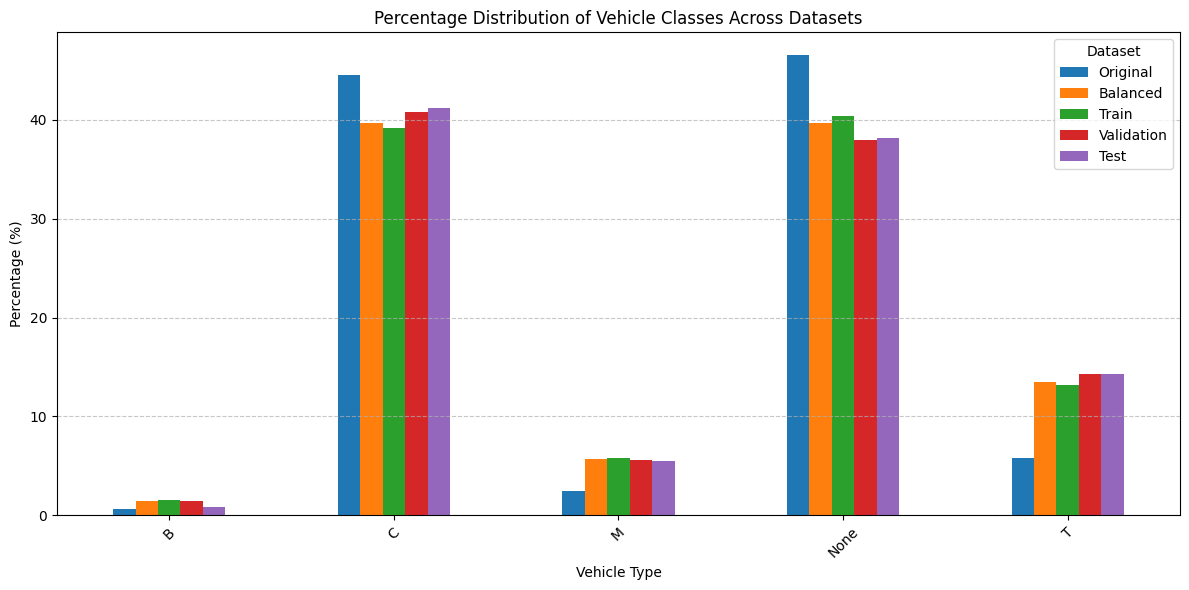

In [24]:
# Reshape per CNN (aggiunge canale)
spectograms_reshaped = spectograms.reshape(spectograms.shape[0], spectograms.shape[1], spectograms.shape[2], 1)

 
# Create balanced dataset
balanced_spectrograms_3000, balanced_audio_features_3000, balanced_vehicle_labels_3000, balanced_direction_labels_3000 = create_balanced_dataset(
    spectograms_reshaped, 
    audio_features_scaled,  # Aggiungi le feature audio
    labels_cat_vehicles, 
    labels_cat_direction,
    target_count = 3000
)

# Split the balanced dataset
# 1. First split: Train (70%) and Temporary (30%)
X_train_bal_3000, X_temp_bal_3000, audio_features_train, audio_features_temp, y_train_vehicle_bal_3000, y_temp_vehicle_bal_3000, y_train_direction_bal_3000, y_temp_direction_bal_3000 = train_test_split(
    balanced_spectrograms_3000, 
    balanced_audio_features_3000,  # Aggiungi le feature audio
    balanced_vehicle_labels_3000, 
    balanced_direction_labels_3000,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# 2. Second split: Temporary into Validation (15%) and Test (15%)
X_val_bal_3000, X_test_bal_3000, audio_features_val, audio_features_test, y_val_vehicle_bal_3000, y_test_vehicle_bal_3000, y_val_direction_bal_3000, y_test_direction_bal_3000 = train_test_split(
    X_temp_bal_3000,
    audio_features_temp,  # Aggiungi le feature audio
    y_temp_vehicle_bal_3000, 
    y_temp_direction_bal_3000,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

# STAMPE

# 1. Count in the full dataset (original, unbalanced)
vehicle_counts_full = df_dataset["vehicle"].value_counts()
print("\nNumber of audio files per vehicle class (Original Full Dataset):")
print(vehicle_counts_full)

# Get the class distribution in the balanced dataset
balanced_vehicle_indices = np.argmax(balanced_vehicle_labels_3000, axis=1)
balanced_counts_full = pd.Series(balanced_vehicle_indices).map(lambda idx: le_vehicle.classes_[idx]).value_counts()
print("\nNumber of audio files per vehicle class (Balanced Full Dataset):")
print(balanced_counts_full)

# 2. Count in the balanced split datasets
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train_vehicle_bal_3000, axis=1)
y_val_indices = np.argmax(y_val_vehicle_bal_3000, axis=1)
y_test_indices = np.argmax(y_test_vehicle_bal_3000, axis=1)

# Get the class names in the correct order
class_names = le_vehicle.classes_

# Create DataFrames for counting
train_counts = pd.Series(y_train_indices).map(lambda idx: class_names[idx]).value_counts()
val_counts = pd.Series(y_val_indices).map(lambda idx: class_names[idx]).value_counts()
test_counts = pd.Series(y_test_indices).map(lambda idx: class_names[idx]).value_counts()

# Ensure all classes are present in each count (even if zero)
for counts in [train_counts, val_counts, test_counts, balanced_counts_full]:
    for class_name in class_names:
        if class_name not in counts:
            counts[class_name] = 0
    counts.sort_index(inplace=True)

# Print counts for each split
print("\nNumber of audio files per vehicle class (Balanced Training Set):")
print(train_counts)
print("\nNumber of audio files per vehicle class (Balanced Validation Set):")
print(val_counts)
print("\nNumber of audio files per vehicle class (Balanced Test Set):")
print(test_counts)

# Visualize the class distribution
plt.figure(figsize=(15, 10))

# Original full dataset
plt.subplot(2, 3, 1)
vehicle_counts_full.plot(kind='bar', color='skyblue')
plt.title('Original Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced full dataset
plt.subplot(2, 3, 2)
balanced_counts_full.plot(kind='bar', color='lightblue')
plt.title('Balanced Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced training set
plt.subplot(2, 3, 4)
train_counts.plot(kind='bar', color='lightgreen')
plt.title('Balanced Training Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced validation set
plt.subplot(2, 3, 5)
val_counts.plot(kind='bar', color='salmon')
plt.title('Balanced Validation Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced test set
plt.subplot(2, 3, 6)
test_counts.plot(kind='bar', color='orchid')
plt.title('Balanced Test Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a percentage distribution chart for comparison
plt.figure(figsize=(12, 6))

# Create a DataFrame with all counts for easy comparison
counts_df = pd.DataFrame({
    'Original': vehicle_counts_full / vehicle_counts_full.sum() * 100,
    'Balanced': balanced_counts_full / balanced_counts_full.sum() * 100,
    'Train': train_counts / train_counts.sum() * 100,
    'Validation': val_counts / val_counts.sum() * 100,
    'Test': test_counts / test_counts.sum() * 100
})

# Plot percentage distribution
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Vehicle Classes Across Datasets')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 8
# ------------------------------------------------------------------------------

'''
Modello a 2 rami che convergono
1. Ramo CNN per gli spettrogrammi
2. Ramo CNN per le feature audio 

20 secondi a epoch
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(5, activation='softmax')(x)

# Modello completo
model_8 = tf.keras.Model(inputs=[input_spectrogram, input_features], outputs=output)

model_8.summary()


model_8.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_8.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 126, 186,  │        640 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 63, 93,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 63, 93,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 91,    │     36,928 │ dropout_15[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 30, 45,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 30, 45,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 43,    │     18,464 │ dropout_16[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 21,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      1,088 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 14, 21,    │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 19,    │      4,624 │ dropout_17[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,160 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 9, 16)  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,577,621 (6.02 MB)

 Trainable params: 1,577,621 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_8 = model_8.fit(
    [X_train_bal_3000, audio_features_train],  # inputs
    y_train_vehicle_bal_3000,                  # target
    epochs=150,
    batch_size=32,
    validation_data=([X_val_bal_3000, audio_features_val], y_val_vehicle_bal_3000),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8472 - loss: 0.3648

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.8472 - loss: 0.3647 - val_accuracy: 0.8448 - val_loss: 0.3969
Epoch 2/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.8584 - loss: 0.3595 - val_accuracy: 0.8439 - val_loss: 0.4100
Epoch 3/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.8485 - loss: 0.3547 - val_accuracy: 0.8430 - val_loss: 0.4274
Epoch 4/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8551 - loss: 0.3563

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8551 - loss: 0.3562 - val_accuracy: 0.8501 - val_loss: 0.3605
Epoch 5/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8588 - loss: 0.3347

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.8588 - loss: 0.3347 - val_accuracy: 0.8589 - val_loss: 0.3461
Epoch 6/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8690 - loss: 0.3146 - val_accuracy: 0.8422 - val_loss: 0.3938
Epoch 7/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8581 - loss: 0.3474

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8582 - loss: 0.3472 - val_accuracy: 0.8492 - val_loss: 0.3460
Epoch 8/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8775 - loss: 0.3091 - val_accuracy: 0.8413 - val_loss: 0.3798
Epoch 9/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8506 - loss: 0.3348

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.8508 - loss: 0.3346 - val_accuracy: 0.8836 - val_loss: 0.3240
Epoch 10/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8771 - loss: 0.2999 - val_accuracy: 0.8580 - val_loss: 0.3259
Epoch 11/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8688 - loss: 0.3113 - val_accuracy: 0.8589 - val_loss: 0.3260
Epoch 12/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8863 - loss: 0.2749 - val_accuracy: 0.8633 - val_loss: 0.3282
Epoch 13/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8889 - loss: 0.2760 - val_accuracy: 0.8624 - val_loss: 0.3351
Epoch 14/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.8769 - loss: 0.2845 - val_accuracy: 0.8624 - val_loss: 0.3556
Epoch 15/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.8761 - loss: 0.2900 - val_accuracy: 0.8642 - val_loss: 0.3503
Epoch 16/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.8765 - loss

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8840 - loss: 0.2891 - val_accuracy: 0.8730 - val_loss: 0.3186
Epoch 18/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8890 - loss: 0.2615 - val_accuracy: 0.8563 - val_loss: 0.3450
Epoch 19/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8862 - loss: 0.2782 - val_accuracy: 0.8668 - val_loss: 0.3198
Epoch 20/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8806 - loss: 0.2841 - val_accuracy: 0.8624 - val_loss: 0.3278
Epoch 21/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8933 - loss: 0.2521 - val_accuracy: 0.8607 - val_loss: 0.3341
Epoch 22/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8970 - loss: 0.2566 - val_accuracy: 0.8624 - val_loss: 0.3379
Epoch 23/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8919 - loss: 0.2575

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8920 - loss: 0.2575 - val_accuracy: 0.8730 - val_loss: 0.3044
Epoch 24/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.8914 - loss: 0.2605 - val_accuracy: 0.8748 - val_loss: 0.3097
Epoch 25/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8962 - loss: 0.2487 - val_accuracy: 0.8757 - val_loss: 0.3064
Epoch 26/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9012 - loss: 0.2507 - val_accuracy: 0.8668 - val_loss: 0.3165
Epoch 27/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8940 - loss: 0.2541

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8940 - loss: 0.2541 - val_accuracy: 0.8765 - val_loss: 0.3000
Epoch 28/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9015 - loss: 0.2419

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.9015 - loss: 0.2419 - val_accuracy: 0.8748 - val_loss: 0.2925
Epoch 29/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.9025 - loss: 0.2466 - val_accuracy: 0.8774 - val_loss: 0.2975
Epoch 30/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.9030 - loss: 0.2335 - val_accuracy: 0.8757 - val_loss: 0.2960
Epoch 31/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9043 - loss: 0.2337 - val_accuracy: 0.8580 - val_loss: 0.3215
Epoch 32/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9059 - loss: 0.2364 - val_accuracy: 0.8624 - val_loss: 0.3154
Epoch 33/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9006 - loss: 0.2339 - val_accuracy: 0.8677 - val_loss: 0.3235
Epoch 34/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9058 - loss: 0.2207 - val_accuracy: 0.8730 - val_loss: 0.2986
Epoch 35/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9077 - loss:

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9077 - loss: 0.2266 - val_accuracy: 0.8765 - val_loss: 0.2907
Epoch 36/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9072 - loss: 0.2162 - val_accuracy: 0.8765 - val_loss: 0.2930
Epoch 37/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9141 - loss: 0.2163 - val_accuracy: 0.8721 - val_loss: 0.3099
Epoch 38/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9153 - loss: 0.2141 - val_accuracy: 0.8739 - val_loss: 0.3193
Epoch 39/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9069 - loss: 0.2188 - val_accuracy: 0.8836 - val_loss: 0.3051
Epoch 40/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9156 - loss: 0.1983 - val_accuracy: 0.8757 - val_loss: 0.3131
Epoch 41/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9119 - loss: 0.2142 - val_accuracy: 0.8607 - val_loss: 0.3328
Epoch 42/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9063 - loss

In [29]:
# TEST
best_model_8 = tf.keras.models.load_model('best_model_8.h5')

test_loss_8, test_acc_8 = model_8.evaluate([X_test_bal_3000, audio_features_test], y_test_vehicle_bal_3000, verbose=1)
print(f"\nTest accuracy: {test_acc_8:.4f}")
print(f"Test loss: {test_loss_8:.4f}")

y_pred_prob_8 = model_8.predict([X_test_bal_3000, audio_features_test])
y_pred_8 = np.argmax(y_pred_prob_8, axis=1)
y_true_8 = np.argmax(y_test_vehicle_bal_3000, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8917 - loss: 0.2533

Test accuracy: 0.9012
Test loss: 0.2452
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


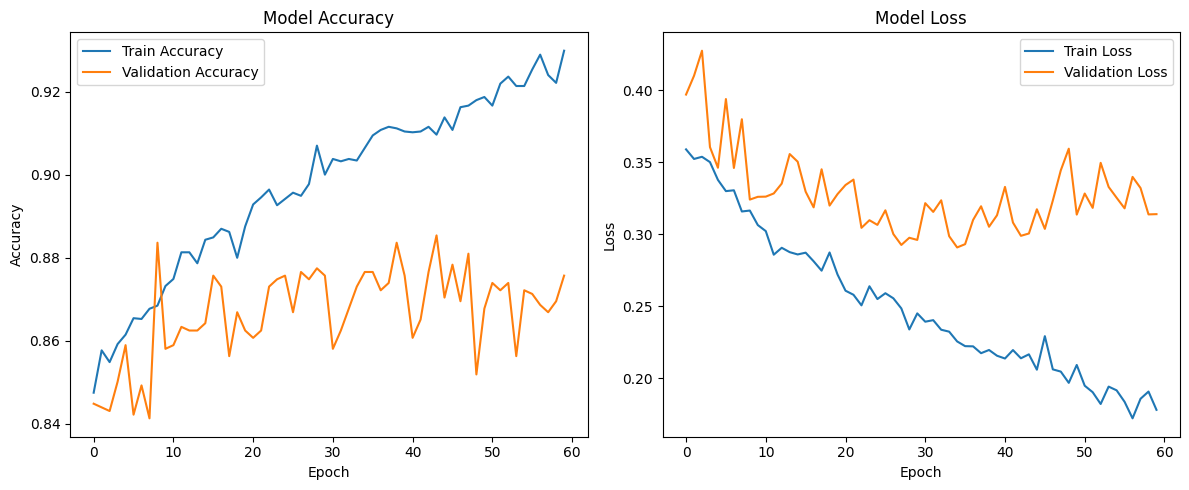

Miglior accuracy: 0.8854 (epoch 44)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.78      0.70      0.74        10
           C       0.84      0.95      0.89       467
           M       1.00      1.00      1.00        62
        None       0.99      0.99      0.99       433
           T       0.78      0.51      0.62       162

    accuracy                           0.90      1134
   macro avg       0.88      0.83      0.85      1134
weighted avg       0.90      0.90      0.89      1134



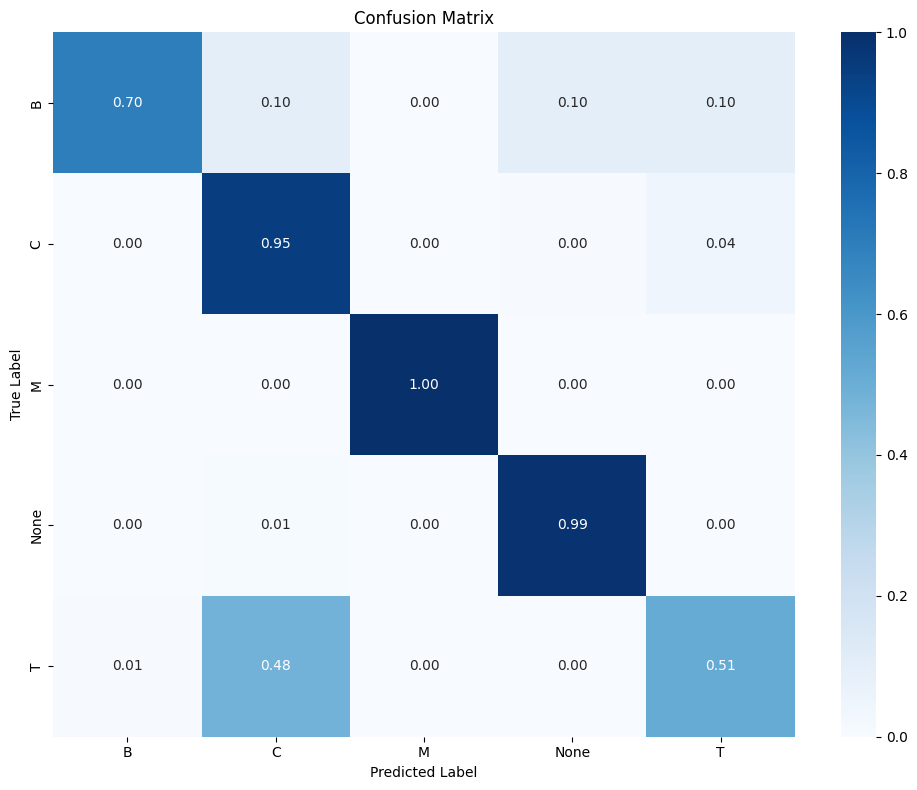

In [30]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_8, y_true_8, y_pred_8, class_names=le_vehicle.classes_)

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 9
# ------------------------------------------------------------------------------

'''
Come modello 8, ma con tutto il dataset

55 secondi a epoch

Prestazioni migliori rispetto agli altri
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(5, activation='softmax')(x)

# Modello completo
model_9 = tf.keras.Model(inputs=[input_spectrogram, input_features], outputs=output)

model_9.summary()


model_9.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_9.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 126, 186,  │        640 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 63, 93,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 63, 93,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 61, 91,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 30, 45,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 30, 45,    │          0 │ max_pooling2d_17… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 43,    │     18,464 │ dropout_23[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 14, 21,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      1,088 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 14, 21,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 12, 19,    │      4,624 │ dropout_24[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      4,160 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 6, 9, 16)  │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,577,621 (6.02 MB)

 Trainable params: 1,577,621 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Dataset Split corretto per multi-input e multi-output (feature audio e spettrogrammi, più tipi di etichette)

# Reshape per CNN (aggiunge canale)
spectograms_reshaped = spectograms.reshape(spectograms.shape[0], spectograms.shape[1], spectograms.shape[2], 1)

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectograms_reshaped, 
    audio_features_scaled,  # Feature audio per il secondo ramo
    labels_cat_vehicles, 
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp, 
    audio_features_temp,   # Feature audio temporanee da dividere
    y_temp_vehicle, 
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input spettrogrammi: {X_train.shape[1:]}")
print(f"Dimensione input feature audio: {audio_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)


ValueError: cannot reshape array of size 842528768 into shape (17506,2,128,1)

In [34]:
history_9 = model_9.fit(
    [X_train, audio_features_train],  # inputs
    y_train_vehicle,                  # target
    epochs=150,
    batch_size=32,
    validation_data=([X_val, audio_features_val], y_val_vehicle),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7920 - loss: 0.6161

383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.7921 - loss: 0.6157 - val_accuracy: 0.8823 - val_loss: 0.4849
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.8928 - loss: 0.3457 - val_accuracy: 0.8892 - val_loss: 0.5220
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9053 - loss: 0.2964

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - accuracy: 0.9053 - loss: 0.2964 - val_accuracy: 0.9158 - val_loss: 0.3365
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9114 - loss: 0.2824

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - accuracy: 0.9114 - loss: 0.2824 - val_accuracy: 0.9246 - val_loss: 0.2599
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - accuracy: 0.9142 - loss: 0.2676 - val_accuracy: 0.9261 - val_loss: 0.2744
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.9156 - loss: 0.2588 - val_accuracy: 0.9269 - val_loss: 0.2896
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9182 - loss: 0.2516

383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9182 - loss: 0.2516 - val_accuracy: 0.9303 - val_loss: 0.2564
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9202 - loss: 0.2452

383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9202 - loss: 0.2452 - val_accuracy: 0.9284 - val_loss: 0.2186
Epoch 9/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.9240 - loss: 0.2256 - val_accuracy: 0.9311 - val_loss: 0.2272
Epoch 10/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9265 - loss: 0.2230

383/383 ━━━━━━━━━━━━━━━━━━━━ 62s 162ms/step - accuracy: 0.9265 - loss: 0.2230 - val_accuracy: 0.9322 - val_loss: 0.2075
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - accuracy: 0.9245 - loss: 0.2231 - val_accuracy: 0.9299 - val_loss: 0.2614
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9206 - loss: 0.2268

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.9206 - loss: 0.2267 - val_accuracy: 0.9341 - val_loss: 0.2033
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9252 - loss: 0.2115 - val_accuracy: 0.9326 - val_loss: 0.2096
Epoch 14/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9266 - loss: 0.2175

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9266 - loss: 0.2175 - val_accuracy: 0.9349 - val_loss: 0.1976
Epoch 15/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 142ms/step - accuracy: 0.9246 - loss: 0.2138 - val_accuracy: 0.9242 - val_loss: 0.2217
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9255 - loss: 0.2052 - val_accuracy: 0.9337 - val_loss: 0.2428
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9306 - loss: 0.1971

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.9306 - loss: 0.1971 - val_accuracy: 0.9372 - val_loss: 0.1946
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9290 - loss: 0.2003

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.9290 - loss: 0.2003 - val_accuracy: 0.9410 - val_loss: 0.1852
Epoch 19/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.9300 - loss: 0.1993 - val_accuracy: 0.9440 - val_loss: 0.1879
Epoch 20/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9305 - loss: 0.1996

383/383 ━━━━━━━━━━━━━━━━━━━━ 61s 158ms/step - accuracy: 0.9305 - loss: 0.1996 - val_accuracy: 0.9429 - val_loss: 0.1788
Epoch 21/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9359 - loss: 0.1830 - val_accuracy: 0.9402 - val_loss: 0.1941
Epoch 22/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9322 - loss: 0.1890 - val_accuracy: 0.9429 - val_loss: 0.1874
Epoch 23/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.9326 - loss: 0.1854 - val_accuracy: 0.9406 - val_loss: 0.1865
Epoch 24/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 136ms/step - accuracy: 0.9381 - loss: 0.1745 - val_accuracy: 0.9395 - val_loss: 0.1950
Epoch 25/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9295 - loss: 0.1933 - val_accuracy: 0.9288 - val_loss: 0.2194
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - accuracy: 0.9421 - loss: 0.1770 - val_accuracy: 0.9429 - val_loss: 0.1817
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.9352 - loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - accuracy: 0.9352 - loss: 0.1822 - val_accuracy: 0.9421 - val_loss: 0.1761
Epoch 29/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 142ms/step - accuracy: 0.9366 - loss: 0.1713 - val_accuracy: 0.9452 - val_loss: 0.1861
Epoch 30/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - accuracy: 0.9390 - loss: 0.1713 - val_accuracy: 0.9368 - val_loss: 0.2063
Epoch 31/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9380 - loss: 0.1731 - val_accuracy: 0.9436 - val_loss: 0.1990
Epoch 32/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9388 - loss: 0.1649

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9388 - loss: 0.1649 - val_accuracy: 0.9410 - val_loss: 0.1754
Epoch 33/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9385 - loss: 0.1683

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9385 - loss: 0.1683 - val_accuracy: 0.9448 - val_loss: 0.1732
Epoch 34/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.9442 - loss: 0.1556 - val_accuracy: 0.9406 - val_loss: 0.1876
Epoch 35/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9380 - loss: 0.1678 - val_accuracy: 0.9250 - val_loss: 0.2084
Epoch 36/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 150ms/step - accuracy: 0.9405 - loss: 0.1627 - val_accuracy: 0.9322 - val_loss: 0.2006
Epoch 37/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 152ms/step - accuracy: 0.9420 - loss: 0.1537 - val_accuracy: 0.9463 - val_loss: 0.1900
Epoch 38/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9472 - loss: 0.1530 - val_accuracy: 0.9429 - val_loss: 0.1802
Epoch 39/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - accuracy: 0.9452 - loss: 0.1484 - val_accuracy: 0.9276 - val_loss: 0.2175
Epoch 40/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 148ms/step - accuracy: 0.9427 - loss

In [37]:
# TEST
best_model_9 = tf.keras.models.load_model('best_model_9.h5')

test_loss_9, test_acc_9 = model_9.evaluate([X_test, audio_features_test], y_test_vehicle, verbose=1)
print(f"\nTest accuracy: {test_acc_9:.4f}")
print(f"Test loss: {test_loss_9:.4f}")

y_pred_prob_9 = model_9.predict([X_test, audio_features_test])
y_pred_9 = np.argmax(y_pred_prob_9, axis=1)
y_true_9 = np.argmax(y_test_vehicle, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9518 - loss: 0.1704

Test accuracy: 0.9459
Test loss: 0.1767
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


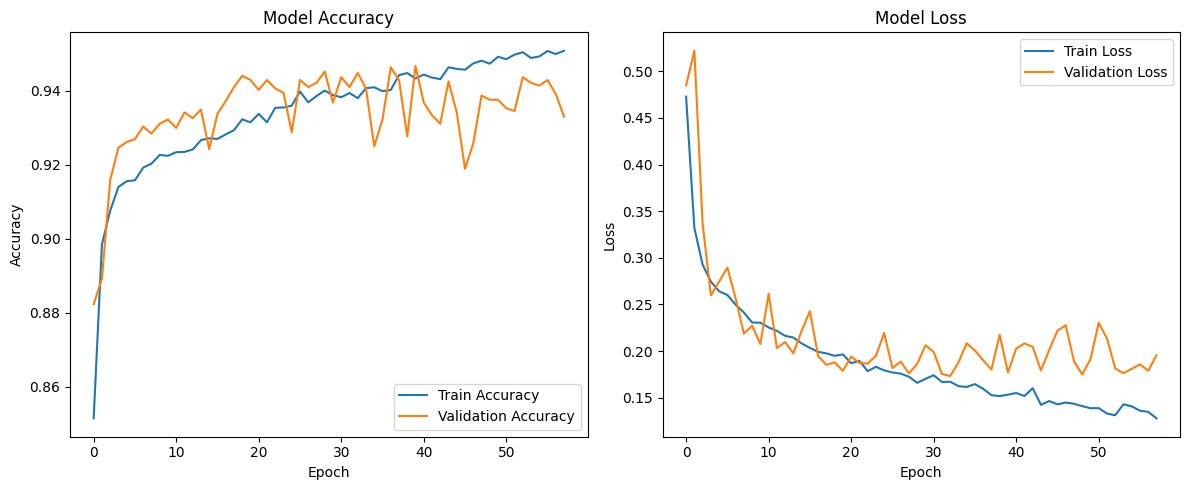

Miglior accuracy: 0.9467 (epoch 40)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.69      0.82      0.75        22
           C       0.92      0.97      0.95      1177
           M       1.00      0.97      0.98        58
        None       0.99      0.99      0.99      1213
           T       0.68      0.42      0.52       156

    accuracy                           0.95      2626
   macro avg       0.86      0.83      0.84      2626
weighted avg       0.94      0.95      0.94      2626



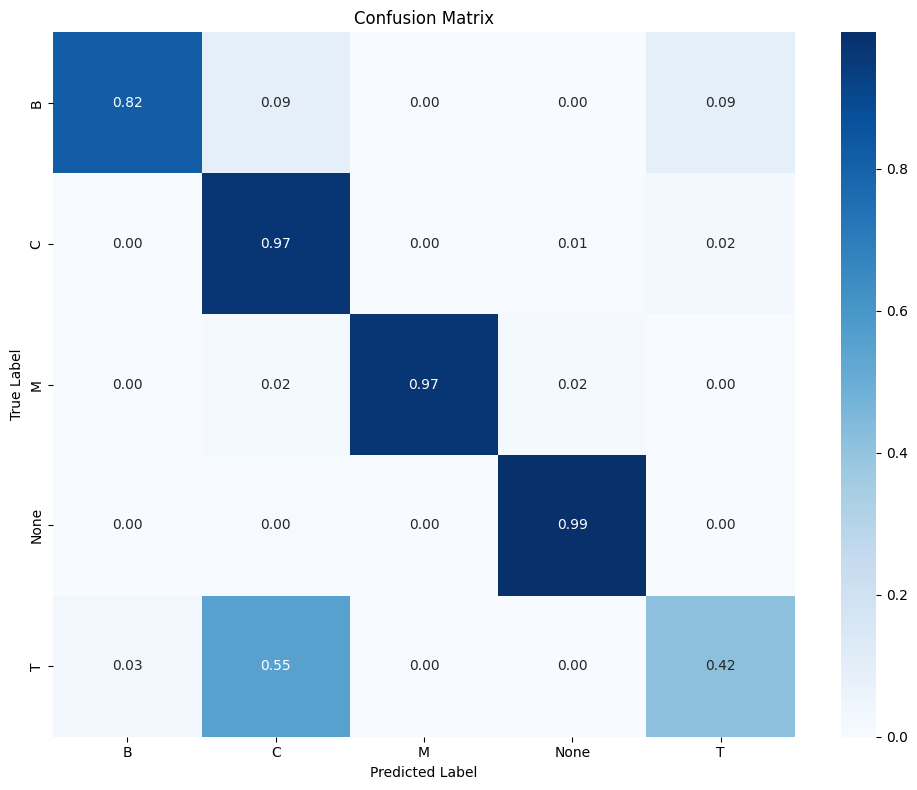

In [38]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_9, y_true_9, y_pred_9, class_names=le_vehicle.classes_)

In [ ]:
def analyze_audio_channels(file_list):
    """
    Analizza il numero di canali audio nei file del database.
    
    Args:
        file_list: Lista di percorsi ai file audio
    
    Returns:
        tuple: (conteggio_stereo, conteggio_mono, dettagli_per_file)
    """
    mono_count = 0
    stereo_count = 0
    file_details = []
    
    # Loop attraverso tutti i file con progress bar
    for file_path in tqdm(file_list, desc="Analisi file audio"):
        try:
            # Carica il file preservando i canali
            y, sr = librosa.load(file_path, sr=None, mono=False)
            
            # Controlla se è mono o stereo
            if y.ndim == 1:  # Mono (1 dimensione)
                mono_count += 1
                channels = 1
            else:  # Stereo (2 dimensioni)
                stereo_count += 1
                channels = y.shape[0]
            
            # Aggiungi dettagli
            file_name = os.path.basename(file_path)
            file_details.append({
                'file': file_name,
                'channels': channels,
                'tipo': 'mono' if channels == 1 else 'stereo'
            })
            
        except Exception as e:
            print(f"Errore nell'analisi del file {file_path}: {e}")
    
    return stereo_count, mono_count, file_details

# Esegui l'analisi
stereo_count, mono_count, details = analyze_audio_channels(all_audio_files)

# Stampa i risultati
print("\n------ ANALISI CANALI AUDIO ------")
print(f"Numero di file stereo: {stereo_count}")
print(f"Numero di file mono: {mono_count}")
print(f"Totale file analizzati: {stereo_count + mono_count}")
print(f"Percentuale stereo: {stereo_count/(stereo_count + mono_count)*100:.1f}%")
print(f"Percentuale mono: {mono_count/(stereo_count + mono_count)*100:.1f}%")

# Opzionale: salva i dettagli in un CSV
import pandas as pd
df_details = pd.DataFrame(details)
print("\nPrimi 5 file analizzati:")
print(df_details.head())

# Opzionale: salva in CSV
# df_details.to_csv("audio_channels_analysis.csv", index=False)

Analisi file audio: 100%|██████████| 17506/17506 [02:30<00:00, 116.21it/s]



------ ANALISI CANALI AUDIO ------
Numero di file stereo: 17506
Numero di file mono: 0
Totale file analizzati: 17506
Percentuale stereo: 100.0%
Percentuale mono: 0.0%

Primi 5 file analizzati:
                                                file  channels    tipo
0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...         2  stereo


In [25]:
# ------------------------------------------------------------------------------
# STEREO
# ------------------------------------------------------------------------------

# Dataset Split corretto per multi-input e multi-output (feature audio e spettrogrammi, più tipi di etichette)

# Reshape per CNN (aggiunge canale)
print(f"Dimensione spettrogrammi prima del reshape: {spectograms.shape}")
# spectograms_reshaped = spectograms.reshape(spectograms.shape[0], spectograms.shape[1], spectograms.shape[2], 1)
spectograms_reshaped = spectograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Dimensione spettrogrammi dopo il reshape: {spectograms_reshaped.shape}")

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectograms_reshaped, 
    audio_features_scaled,  # Feature audio per il secondo ramo
    labels_cat_vehicles, 
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp, 
    audio_features_temp,   # Feature audio temporanee da dividere
    y_temp_vehicle, 
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print()
print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input spettrogrammi: {X_train.shape[1:]}")
print(f"Dimensione input feature audio: {audio_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 128, 188, 2)

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input spettrogrammi: (128, 188, 2)
Dimensione input feature audio: (25,)


In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 10
# ------------------------------------------------------------------------------

'''
Come modello 9, ma doppio output per vehicle e direction

55 secondi a epoch
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output branch per i veicoli
vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x)

# Output branch per la direzione (3 classi: left, right, none)
direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x)


# Modello completo con doppio output
model_10 = tf.keras.Model(
    inputs=[input_spectrogram, input_features], 
    outputs=[vehicle_output, direction_output]
)

model_10.summary()


# Compilation con doppio obiettivo e perdita
model_10.compile(
    optimizer='adam',
    loss={
        'vehicle_output': 'categorical_crossentropy',
        'direction_output': 'categorical_crossentropy'
    },
    metrics={
        'vehicle_output': ['accuracy'],
        'direction_output': ['accuracy']
    },
    loss_weights={
        'vehicle_output': 1.0, 
        'direction_output': 1.0  # Puoi bilanciare l'importanza degli output
    }
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_10.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 93,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 93,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 91,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 45,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 45,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 43,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 21,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 21,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 19,    │      4,624 │ dropout_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 9, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 9, 16)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,579,160 (6.02 MB)

 Trainable params: 1,579,160 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Per l'addestramento, dovrai passare entrambi gli output
history_10 = model_10.fit(
    [X_train, audio_features_train],  # inputs
    {
        'vehicle_output': y_train_vehicle,
        'direction_output': y_train_direction
    },  # targets
    epochs=150,
    batch_size=32,
    validation_data=(
        [X_val, audio_features_val], 
        {
            'vehicle_output': y_val_vehicle,
            'direction_output': y_val_direction
        }
    ),
    callbacks=[early_stopping, model_checkpoint]
)

# loss è la somma di direction_output_loss e vehicle_output_loss

Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - direction_output_accuracy: 0.6251 - direction_output_loss: 0.7004 - loss: 1.3563 - vehicle_output_accuracy: 0.7628 - vehicle_output_loss: 0.6559

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 124ms/step - direction_output_accuracy: 0.6253 - direction_output_loss: 0.7000 - loss: 1.3555 - vehicle_output_accuracy: 0.7630 - vehicle_output_loss: 0.6555 - val_direction_output_accuracy: 0.7548 - val_direction_output_loss: 0.4729 - val_loss: 0.9336 - val_vehicle_output_accuracy: 0.8960 - val_vehicle_output_loss: 0.4673
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - direction_output_accuracy: 0.7810 - direction_output_loss: 0.4162 - loss: 0.7526 - vehicle_output_accuracy: 0.8954 - vehicle_output_loss: 0.3364

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - direction_output_accuracy: 0.7810 - direction_output_loss: 0.4162 - loss: 0.7526 - vehicle_output_accuracy: 0.8954 - vehicle_output_loss: 0.3364 - val_direction_output_accuracy: 0.8530 - val_direction_output_loss: 0.3779 - val_loss: 0.7081 - val_vehicle_output_accuracy: 0.9101 - val_vehicle_output_loss: 0.3311
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - direction_output_accuracy: 0.8585 - direction_output_loss: 0.3267 - loss: 0.6392 - vehicle_output_accuracy: 0.9032 - vehicle_output_loss: 0.3126

383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - direction_output_accuracy: 0.8586 - direction_output_loss: 0.3266 - loss: 0.6391 - vehicle_output_accuracy: 0.9032 - vehicle_output_loss: 0.3125 - val_direction_output_accuracy: 0.9627 - val_direction_output_loss: 0.1521 - val_loss: 0.4254 - val_vehicle_output_accuracy: 0.9235 - val_vehicle_output_loss: 0.2730
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - direction_output_accuracy: 0.9287 - direction_output_loss: 0.1896 - loss: 0.4793 - vehicle_output_accuracy: 0.9112 - vehicle_output_loss: 0.2897

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - direction_output_accuracy: 0.9288 - direction_output_loss: 0.1896 - loss: 0.4792 - vehicle_output_accuracy: 0.9112 - vehicle_output_loss: 0.2897 - val_direction_output_accuracy: 0.9707 - val_direction_output_loss: 0.1097 - val_loss: 0.3940 - val_vehicle_output_accuracy: 0.9254 - val_vehicle_output_loss: 0.2838
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - direction_output_accuracy: 0.9530 - direction_output_loss: 0.1371 - loss: 0.3946 - vehicle_output_accuracy: 0.9197 - vehicle_output_loss: 0.2575

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - direction_output_accuracy: 0.9530 - direction_output_loss: 0.1371 - loss: 0.3947 - vehicle_output_accuracy: 0.9197 - vehicle_output_loss: 0.2575 - val_direction_output_accuracy: 0.9752 - val_direction_output_loss: 0.0800 - val_loss: 0.3084 - val_vehicle_output_accuracy: 0.9307 - val_vehicle_output_loss: 0.2271
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - direction_output_accuracy: 0.9605 - direction_output_loss: 0.1185 - loss: 0.3745 - vehicle_output_accuracy: 0.9177 - vehicle_output_loss: 0.2560

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - direction_output_accuracy: 0.9605 - direction_output_loss: 0.1184 - loss: 0.3745 - vehicle_output_accuracy: 0.9177 - vehicle_output_loss: 0.2560 - val_direction_output_accuracy: 0.9791 - val_direction_output_loss: 0.0643 - val_loss: 0.2695 - val_vehicle_output_accuracy: 0.9341 - val_vehicle_output_loss: 0.2029
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - direction_output_accuracy: 0.9645 - direction_output_loss: 0.1111 - loss: 0.3653 - vehicle_output_accuracy: 0.9201 - vehicle_output_loss: 0.2543 - val_direction_output_accuracy: 0.9798 - val_direction_output_loss: 0.0604 - val_loss: 0.2734 - val_vehicle_output_accuracy: 0.9330 - val_vehicle_output_loss: 0.2112
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - direction_output_accuracy: 0.9627 - direction_output_loss: 0.1020 - loss: 0.3434 - vehicle_output_accuracy: 0.9199 - vehicle_output_loss: 0.2415 - val_direction_output_accuracy: 0.9764 - val_direction_output_loss: 

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - direction_output_accuracy: 0.9681 - direction_output_loss: 0.0973 - loss: 0.3328 - vehicle_output_accuracy: 0.9240 - vehicle_output_loss: 0.2355 - val_direction_output_accuracy: 0.9802 - val_direction_output_loss: 0.0605 - val_loss: 0.2687 - val_vehicle_output_accuracy: 0.9353 - val_vehicle_output_loss: 0.2062
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - direction_output_accuracy: 0.9723 - direction_output_loss: 0.0773 - loss: 0.3116 - vehicle_output_accuracy: 0.9200 - vehicle_output_loss: 0.2343 - val_direction_output_accuracy: 0.9760 - val_direction_output_loss: 0.0758 - val_loss: 0.2801 - val_vehicle_output_accuracy: 0.9334 - val_vehicle_output_loss: 0.2032
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - direction_output_accuracy: 0.9765 - direction_output_loss: 0.0728 - loss: 0.3002 - vehicle_output_accuracy: 0.9217 - vehicle_output_loss: 0.2273

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - direction_output_accuracy: 0.9765 - direction_output_loss: 0.0728 - loss: 0.3002 - vehicle_output_accuracy: 0.9217 - vehicle_output_loss: 0.2273 - val_direction_output_accuracy: 0.9848 - val_direction_output_loss: 0.0508 - val_loss: 0.2434 - val_vehicle_output_accuracy: 0.9353 - val_vehicle_output_loss: 0.1912
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - direction_output_accuracy: 0.9754 - direction_output_loss: 0.0727 - loss: 0.2969 - vehicle_output_accuracy: 0.9262 - vehicle_output_loss: 0.2242 - val_direction_output_accuracy: 0.9836 - val_direction_output_loss: 0.0517 - val_loss: 0.2450 - val_vehicle_output_accuracy: 0.9353 - val_vehicle_output_loss: 0.1914
Epoch 14/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - direction_output_accuracy: 0.9793 - direction_output_loss: 0.0640 - loss: 0.2805 - vehicle_output_accuracy: 0.9248 - vehicle_output_loss: 0.2165 - val_direction_output_accuracy: 0.9798 - val_direction_output_loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - direction_output_accuracy: 0.9775 - direction_output_loss: 0.0718 - loss: 0.2971 - vehicle_output_accuracy: 0.9251 - vehicle_output_loss: 0.2253 - val_direction_output_accuracy: 0.9848 - val_direction_output_loss: 0.0479 - val_loss: 0.2383 - val_vehicle_output_accuracy: 0.9341 - val_vehicle_output_loss: 0.1884
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - direction_output_accuracy: 0.9817 - direction_output_loss: 0.0555 - loss: 0.2640 - vehicle_output_accuracy: 0.9284 - vehicle_output_loss: 0.2086

383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - direction_output_accuracy: 0.9817 - direction_output_loss: 0.0555 - loss: 0.2641 - vehicle_output_accuracy: 0.9284 - vehicle_output_loss: 0.2086 - val_direction_output_accuracy: 0.9859 - val_direction_output_loss: 0.0434 - val_loss: 0.2160 - val_vehicle_output_accuracy: 0.9383 - val_vehicle_output_loss: 0.1709
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - direction_output_accuracy: 0.9800 - direction_output_loss: 0.0643 - loss: 0.2720 - vehicle_output_accuracy: 0.9272 - vehicle_output_loss: 0.2077 - val_direction_output_accuracy: 0.9806 - val_direction_output_loss: 0.0564 - val_loss: 0.2447 - val_vehicle_output_accuracy: 0.9379 - val_vehicle_output_loss: 0.1869
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - direction_output_accuracy: 0.9817 - direction_output_loss: 0.0558 - loss: 0.2517 - vehicle_output_accuracy: 0.9320 - vehicle_output_loss: 0.1958 - val_direction_output_accuracy: 0.9836 - val_direction_output_loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 142ms/step - direction_output_accuracy: 0.9884 - direction_output_loss: 0.0351 - loss: 0.1984 - vehicle_output_accuracy: 0.9388 - vehicle_output_loss: 0.1634 - val_direction_output_accuracy: 0.9878 - val_direction_output_loss: 0.0404 - val_loss: 0.2149 - val_vehicle_output_accuracy: 0.9467 - val_vehicle_output_loss: 0.1732
Epoch 40/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - direction_output_accuracy: 0.9897 - direction_output_loss: 0.0313 - loss: 0.1871 - vehicle_output_accuracy: 0.9424 - vehicle_output_loss: 0.1558

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - direction_output_accuracy: 0.9897 - direction_output_loss: 0.0313 - loss: 0.1871 - vehicle_output_accuracy: 0.9424 - vehicle_output_loss: 0.1558 - val_direction_output_accuracy: 0.9878 - val_direction_output_loss: 0.0413 - val_loss: 0.2136 - val_vehicle_output_accuracy: 0.9444 - val_vehicle_output_loss: 0.1705
Epoch 41/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 136ms/step - direction_output_accuracy: 0.9881 - direction_output_loss: 0.0460 - loss: 0.2166 - vehicle_output_accuracy: 0.9361 - vehicle_output_loss: 0.1706 - val_direction_output_accuracy: 0.9829 - val_direction_output_loss: 0.0599 - val_loss: 0.2596 - val_vehicle_output_accuracy: 0.9337 - val_vehicle_output_loss: 0.1977
Epoch 42/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - direction_output_accuracy: 0.9916 - direction_output_loss: 0.0259 - loss: 0.1759 - vehicle_output_accuracy: 0.9435 - vehicle_output_loss: 0.1500

383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - direction_output_accuracy: 0.9916 - direction_output_loss: 0.0259 - loss: 0.1759 - vehicle_output_accuracy: 0.9435 - vehicle_output_loss: 0.1500 - val_direction_output_accuracy: 0.9893 - val_direction_output_loss: 0.0353 - val_loss: 0.2035 - val_vehicle_output_accuracy: 0.9429 - val_vehicle_output_loss: 0.1666
Epoch 43/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - direction_output_accuracy: 0.9910 - direction_output_loss: 0.0312 - loss: 0.1882 - vehicle_output_accuracy: 0.9394 - vehicle_output_loss: 0.1570 - val_direction_output_accuracy: 0.9886 - val_direction_output_loss: 0.0422 - val_loss: 0.2288 - val_vehicle_output_accuracy: 0.9436 - val_vehicle_output_loss: 0.1851
Epoch 44/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - direction_output_accuracy: 0.9904 - direction_output_loss: 0.0303 - loss: 0.1884 - vehicle_output_accuracy: 0.9408 - vehicle_output_loss: 0.1581 - val_direction_output_accuracy: 0.9840 - val_direction_output_loss

In [28]:
# TEST per modello multi-output
best_model_10 = tf.keras.models.load_model('best_model_10.h5')

# Valutazione del modello con entrambi gli output
results = best_model_10.evaluate(
    [X_test, audio_features_test], 
    {
        'vehicle_output': y_test_vehicle,
        'direction_output': y_test_direction
    }, 
    verbose=1
)

# Estrai e stampa le metriche
print("\n--- Risultati test modello multi-output ---")
print(f"Loss totale: {results[0]:.4f}")
print(f"Vehicle output loss: {results[1]:.4f}")
print(f"Direction output loss: {results[2]:.4f}")
print(f"Vehicle accuracy: {results[3]:.4f}")
print(f"Direction accuracy: {results[4]:.4f}")

# Genera predizioni
y_pred_probs = best_model_10.predict([X_test, audio_features_test])
vehicle_pred_probs = y_pred_probs[0]  # Prima uscita: vehicle
direction_pred_probs = y_pred_probs[1]  # Seconda uscita: direction

# Converti probabilità in categorie
vehicle_pred = np.argmax(vehicle_pred_probs, axis=1)
direction_pred = np.argmax(direction_pred_probs, axis=1)
vehicle_true = np.argmax(y_test_vehicle, axis=1)
direction_true = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - direction_output_accuracy: 0.9904 - direction_output_loss: 0.0328 - loss: 0.2245 - vehicle_output_accuracy: 0.9424 - vehicle_output_loss: 0.1917

--- Risultati test modello multi-output ---
Loss totale: 0.2290
Vehicle output loss: 0.1921
Direction output loss: 0.0365
Vehicle accuracy: 0.9897
Direction accuracy: 0.9375
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


In [31]:
def plot_and_evaluate_multi_output_model(history, 
                                         vehicle_true, vehicle_pred, vehicle_class_names,
                                         direction_true, direction_pred, direction_class_names):
    """
    Visualizza le metriche di addestramento e genera i classification report
    per un modello con doppio output (veicolo e direzione).
    
    Args:
        history: Oggetto history restituito da model.fit()
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
    """
    
    # ----- METRICHE DI TRAINING -----
    
    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(15, 10))
    
    # Grafico accuratezza veicoli
    plt.subplot(2, 2, 1)
    plt.plot(history.history['vehicle_output_accuracy'], label='Train Vehicle Accuracy')
    plt.plot(history.history['val_vehicle_output_accuracy'], label='Validation Vehicle Accuracy')
    plt.title('Vehicle Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico loss veicoli
    plt.subplot(2, 2, 2)
    plt.plot(history.history['vehicle_output_loss'], label='Train Vehicle Loss')
    plt.plot(history.history['val_vehicle_output_loss'], label='Validation Vehicle Loss')
    plt.title('Vehicle Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Grafico accuratezza direzione
    plt.subplot(2, 2, 3)
    plt.plot(history.history['direction_output_accuracy'], label='Train Direction Accuracy')
    plt.plot(history.history['val_direction_output_accuracy'], label='Validation Direction Accuracy')
    plt.title('Direction Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico loss direzione
    plt.subplot(2, 2, 4)
    plt.plot(history.history['direction_output_loss'], label='Train Direction Loss')
    plt.plot(history.history['val_direction_output_loss'], label='Validation Direction Loss')
    plt.title('Direction Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Trova e stampa la migliore accuracy per veicoli
    best_vehicle_acc = max(history.history['val_vehicle_output_accuracy'])
    best_vehicle_epoch = history.history['val_vehicle_output_accuracy'].index(best_vehicle_acc) + 1
    print(f"Miglior vehicle accuracy: {best_vehicle_acc:.4f} (epoch {best_vehicle_epoch})")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")
    
    # Trova e stampa la migliore accuracy per direzione
    best_direction_acc = max(history.history['val_direction_output_accuracy'])
    best_direction_epoch = history.history['val_direction_output_accuracy'].index(best_direction_acc) + 1
    print(f"Miglior direction accuracy: {best_direction_acc:.4f} (epoch {best_direction_epoch})")
    
    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

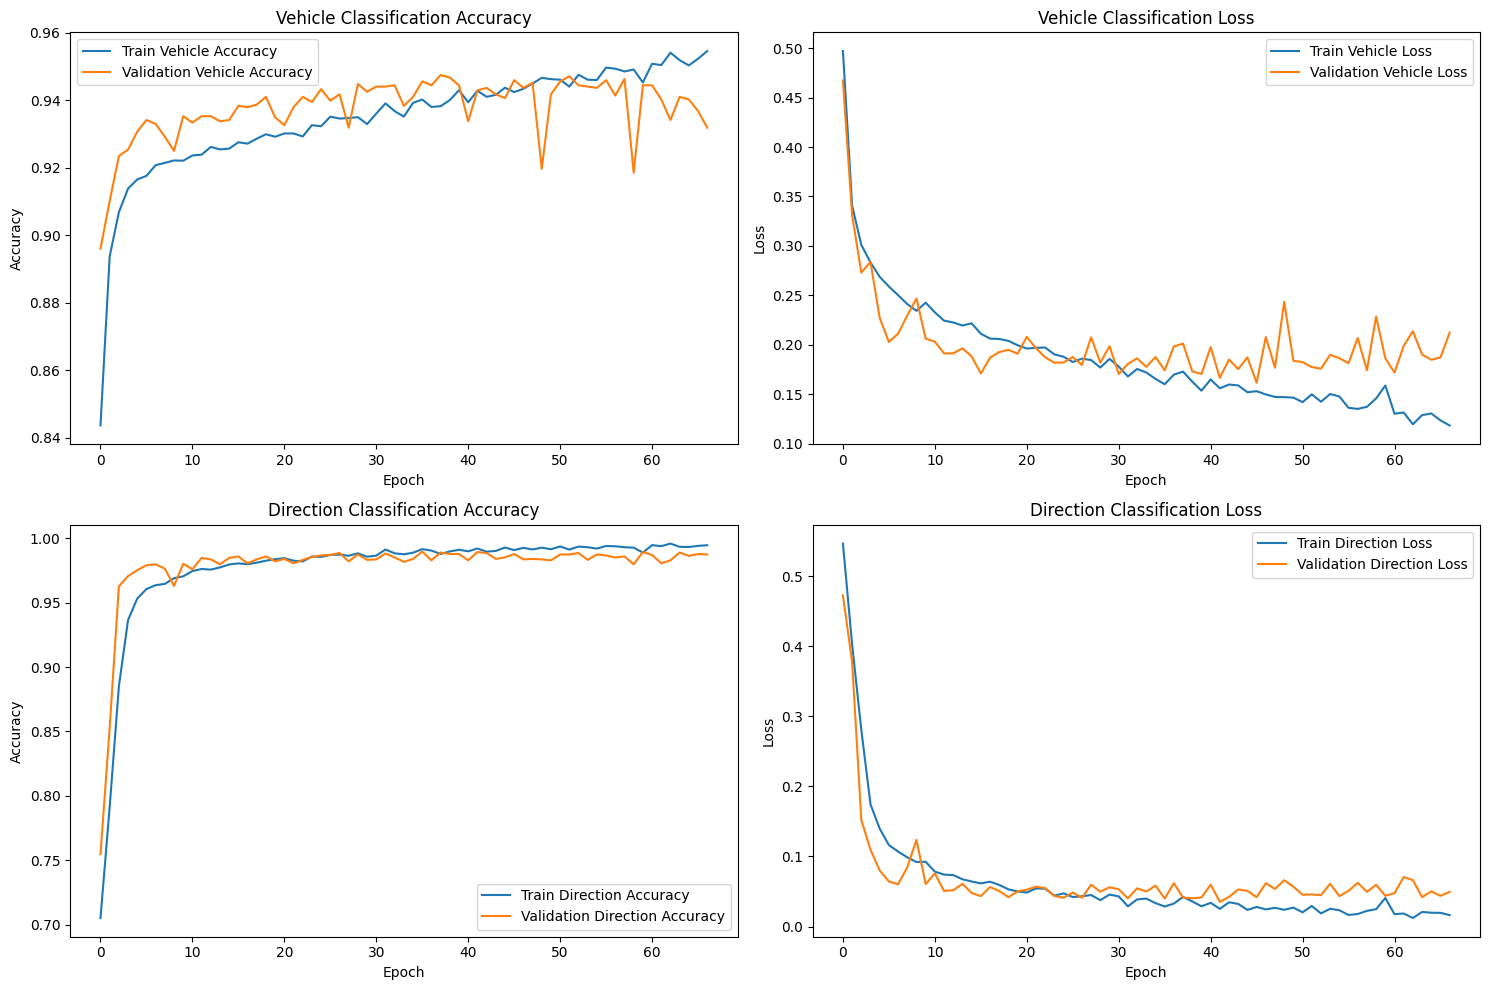


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Miglior vehicle accuracy: 0.9474 (epoch 38)

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.57      0.59      0.58        22
           C       0.89      0.99      0.94      1177
           M       0.98      0.93      0.96        58
        None       1.00      0.99      0.99      1213
           T       0.74      0.18      0.29       156

    accuracy                           0.94      2626
   macro avg       0.83      0.74      0.75      2626
weighted avg       0.93      0.94      0.92      2626



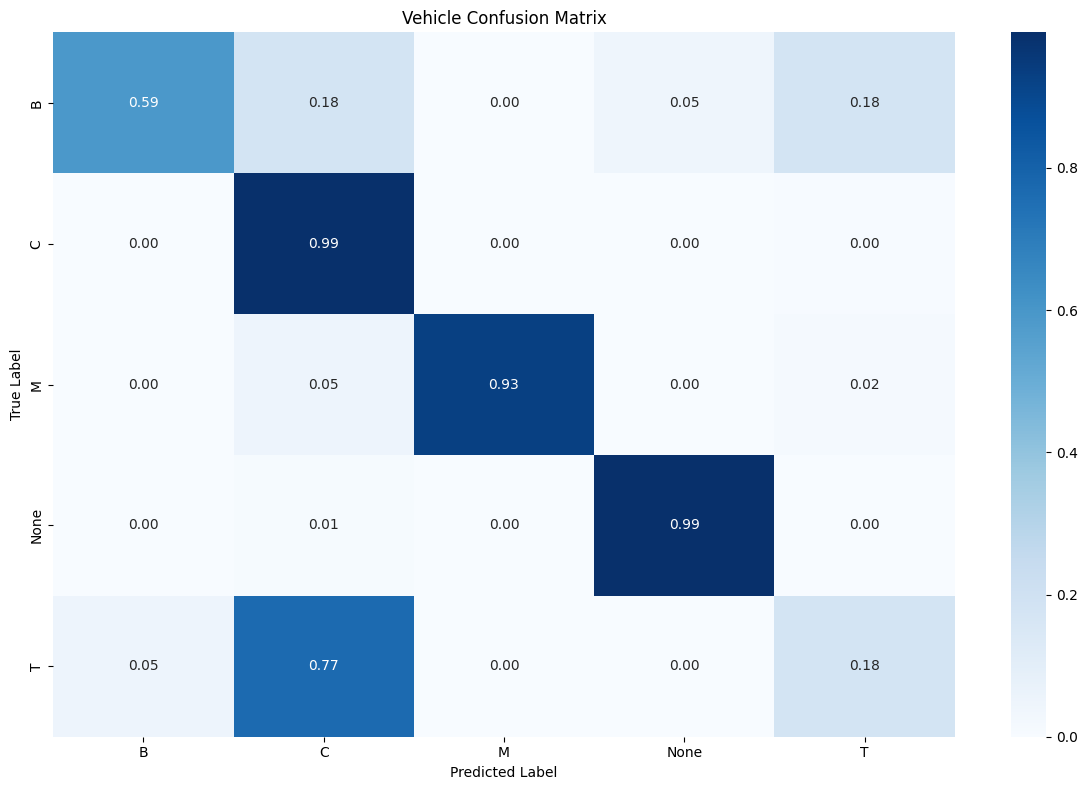


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Miglior direction accuracy: 0.9897 (epoch 36)

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.99      0.99      0.99       715
        None       1.00      0.99      0.99      1213
           R       0.98      0.99      0.99       698

    accuracy                           0.99      2626
   macro avg       0.99      0.99      0.99      2626
weighted avg       0.99      0.99      0.99      2626



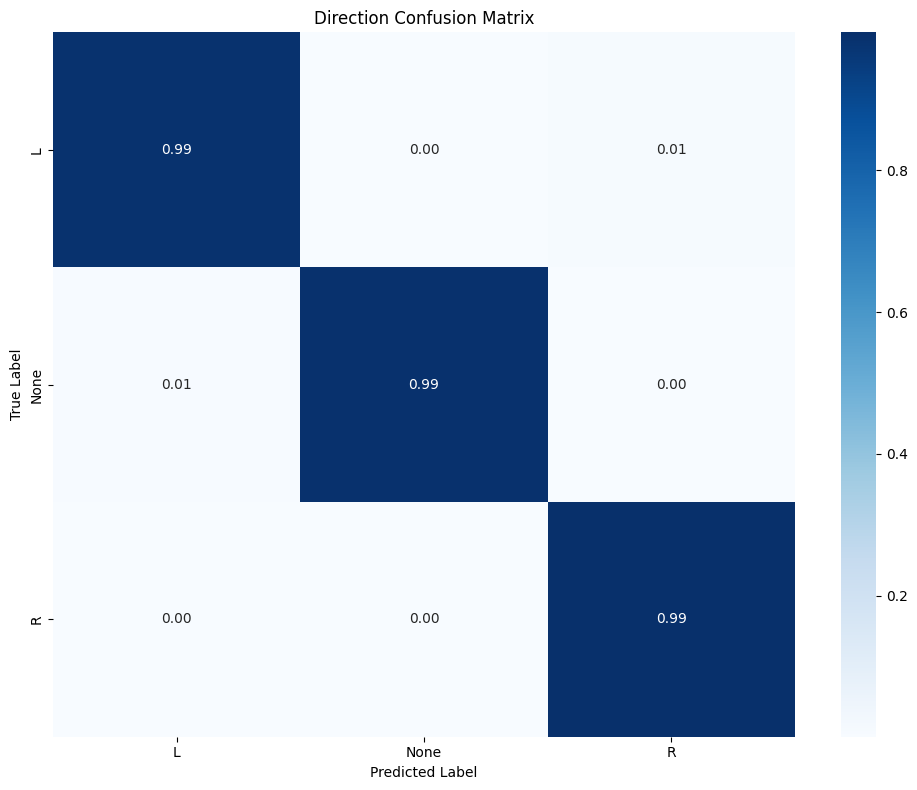

In [32]:
# Sostituisci le due chiamate separate con questa singola chiamata
plot_and_evaluate_multi_output_model(
    history_10,
    vehicle_true, vehicle_pred, le_vehicle.classes_,
    direction_true, direction_pred, le_direction.classes_
)